# Transfer learning - Fine-tuning

In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

Might train more than 1-3 layers

<img src='https://camo.githubusercontent.com/a30cd9d1a1f7b27a2d429dddb2a436ba4e6fd12df16b6623f3385cac6fba333b/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30352d7472616e736665722d6c6561726e696e672d666561747572652d65787472616374696f6e2d76732d66696e652d74756e696e672e706e67' />

### Data exploration

In [67]:
import tensorflow as tf
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [2]:
walk_through_dir('data/10_food_classes_10_percent')

There are 2 directories and 0 images in 'data/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'data/10_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\steak'.
There are 0 di

In [3]:
train_dir = 'data/10_food_classes_10_percent/train/'
test_dir = 'data/10_food_classes_10_percent/test/'

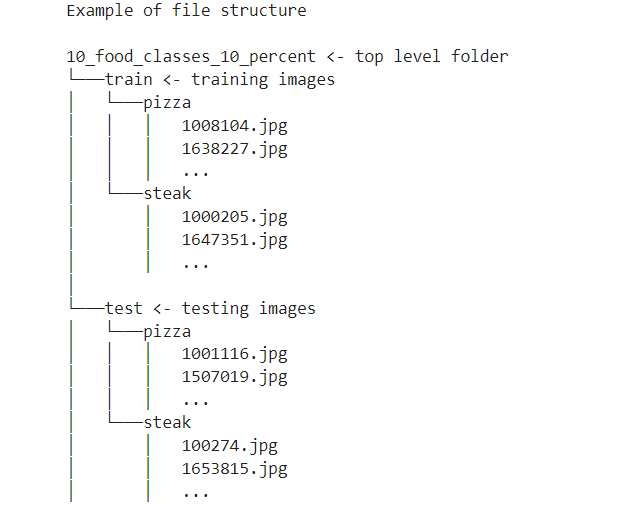

Below the `tf.keras.preprocessing.image_dataset_from_directory()` approach is used rather than the `ImageDataGenerator`. There is pretty much no difference between them, except for the object created. This approach created a `tf.data.Dataset` object rather than a generator, which is much more efficient, while the generator is performs better for larger datasets

The parameters accepted are pretty much the same too.

In [4]:
# Create data inputs
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    # Default batch size
    batch_size=32,
    # Type of labels (outputs)
    label_mode='categorical'
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

`(None, 224, 224, 3)` refer to the tensor shape of the images. `None` being the batch size, `224` being the width and height & `3` being the number of channels

`(None, 10)` refers to the tensor shape of the labels, where `10` is the number of classes

**Side-note** The batch size is always None since it is just a placeholder until its used during model training, where the `image_dataset_from_directory()` would then fill. Until then (The model is trained) it remains as None

In [6]:
# Further inspection shows more advantages
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
# Take the first batch
for images, labels in train_data.take(1):
    print(images.shape, images, labels)

(32, 224, 224, 3) tf.Tensor(
[[[[5.33571434e+01 4.13571434e+01 2.73571434e+01]
   [5.10714264e+01 3.90714264e+01 2.50714283e+01]
   [4.57857132e+01 3.67857132e+01 2.17857132e+01]
   ...
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]]

  [[5.38651161e+01 4.18651161e+01 2.78651142e+01]
   [5.11278687e+01 3.91278687e+01 2.51278687e+01]
   [4.57857132e+01 3.67857132e+01 2.17857132e+01]
   ...
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]]

  [[5.45609055e+01 4.25609055e+01 2.85609055e+01]
   [5.20940666e+01 4.00940666e+01 2.60940685e+01]
   [4.67857132e+01 3.77857132e+01 2.27857132e+01]
   ...
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]]

  ...

  [[1.68274841e+01 3.18462682e+00 0.0

### Build model with Functional API

The Keras functional API also have models that were pretrained (on ImageNet)

In [12]:
# Create feature extraction efficientnet model
base_model = tf.keras.applications.EfficientNetB0(
    # Will add our own top (output) layer
    include_top=False
)

# Freeze base model
base_model.trainable = False

# Create inputs for base model
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,), name='input_layer')

# Normalize input  (Required for Resnet, not for efficientnet: this is built in)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# Pass inputs to base model
x = base_model(inputs)
print(f'Shape after base_model: {x.shape}')

# Add average pooling - transforms 4D tensor to 2D, by averaging values across the inner-axes
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# Create output layer
outputs = tf.keras.layers.Dense(10, activation='linear', name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)
model_0.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history_0 = model_0.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    # Validate for less data so training is faster
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[create_tensorboard_callback('tensorboard_logs_1', 'efficientnetB0')]
    
)

Shape after base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: tensorboard_logs_1/efficientnetB0/20220924-055718
Epoch 1/5
24/24 [==============================] - 89s 3s/step - loss: 1.8699 - accuracy: 0.4560 - val_loss: 1.2970 - val_accuracy: 0.7549
Epoch 2/5
24/24 [==============================] - 75s 3s/step - loss: 1.0921 - accuracy: 0.7680 - val_loss: 0.8679 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 71s 3s/step - loss: 0.7741 - accuracy: 0.8320 - val_loss: 0.6644 - val_accuracy: 0.8635
Epoch 4/5
24/24 [==============================] - 75s 3s/step - loss: 0.6264 - accuracy: 0.8587 - val_loss: 0.6030 - val_accuracy: 0.8503
Epoch 5/5
24/24 [==============================] - 78s 3s/step - loss: 0.5357 - accuracy: 0.8880 - val_loss: 0.5408 - val_accuracy: 0.8651


The `GlobalAveragePooling2D` layer pools the outputs into a shape that is compatible with the outputs (same shape as the labels). `GlobalMaxPooling2D` can also be used, however the former is more common in practice.

In [13]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [14]:
model_0.evaluate(test_data)

79/79 [==============================] - 130s 2s/step - loss: 0.5491 - accuracy: 0.8612


[0.5491406917572021, 0.8611999750137329]

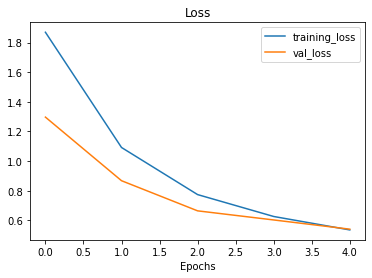

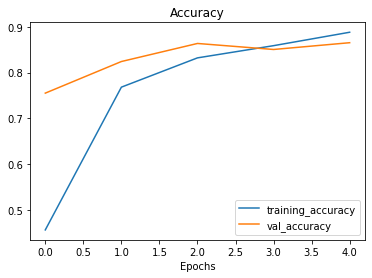

In [15]:
plot_loss_curves(history_0)

### Getting a feature vector from a trained model

Demo what the `GlobalAveragePooling2D` layer does

In [29]:
# Similar 4D tensor
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')
print(input_tensor.shape)

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

(1, 4, 4, 3)


In [27]:
# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n {global_average_pooled_tensor}\n')
print(global_average_pooled_tensor.shape)

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

(1, 3)


It effectively averages the data across the middle two axes (4, 4). Additionally, therefore, creates the required shape (1D vector **feature vector**) for the Dense layer by condensing the information.

A Feature vector is a learned representation of the input data (a compressed form of the input based on how the model see's it)
 * The output of a the pretrained model is the feature vector - which is sent to our output layer

**Side-Note**: One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector (a long tensor of numbers, in this case, it is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of.

In [30]:
# Replicate averaging across middle two axes
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

Demo what the `GlobalMaxPooling2D` layer does

In [31]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f'2D global max pooled random tensor:\n {global_max_pooled_tensor}\n')
print(global_max_pooled_tensor.shape)

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

(1, 3)


In [39]:
tf.reduce_max(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

### Running a series of experiments

* `model_1` Use feature extraction on 1% of data with data augmentation
* `model_2` Use feature extraction on 10% of data with data augmentation
* `model_3` Use fine tuning on 10% of data with data augmentation
* `model_4` Use fine tuning on 100% of data with data augmentation

Test all on the same test dataset

In [20]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
LABEL_MODE = 'categorical'

In [16]:
# Download and unzip data
!curl -O https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  127M    0  3871    0     0   2801      0 13:15:01  0:00:01 13:15:00  2805
  0  127M    0  943k    0     0   515k      0  0:04:12  0:00:01  0:04:11  516k
  2  127M    2 3518k    0     0  1245k      0  0:01:44  0:00:02  0:01:42 1245k
  5  127M    5 6590k    0     0  1722k      0  0:01:15  0:00:03  0:01:12 1723k
  7  127M    7 9870k    0     0  2041k      0  0:01:03  0:00:04  0:00:59 2041k
  9  127M    9 12.1M    0     0  2139k      0  0:01:00  0:00:05  0:00:55 2802k
 11  127M   11 15.0M    0     0  2258k      0  0:00:57  0:00:06  0:00:51 2895k
 14  127M   14 17.9M    0     0  2334k      0  0:00:55  0:00:07  0:00:48 2944k
 16  127M   16 20.5M    0     0  2385k      0  0:00:54  0:00:08  0:00:46 2893k
 18  127M   18 23.5M    0     0  2454k      0  0:00

In [17]:
train_dir_1_percent = 'data/10_food_classes_1_percent/train/'
test_dir = 'data/10_food_classes_1_percent/test/'

In [18]:
walk_through_dir('data/10_food_classes_1_percent')

There are 2 directories and 0 images in 'data/10_food_classes_1_percent'.
There are 10 directories and 0 images in 'data/10_food_classes_1_percent\test'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\steak'.
There are 0 directories a

In [21]:
# Setup data loaders

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode=LABEL_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode=LABEL_MODE,
    image_size=IMG_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation into model

Since the `image_dataset_from_directory` doesn't augment data like `ImageDataGenerator` a separate layer can be added into the model itself. The benefits of this are:
* The augmentation happens on GPU than CPU (`ImageDataGenerator` utilizes CPU). Images are best preprocessed on GPU while text & structured data are more suited for CPU
* Augmentation occurs only during training, so the whole model can be exported and used elsewhere. Futhermore, someone else could train the same model, including the same data augmentation

<img src='https://camo.githubusercontent.com/522ed250e865b937a1d3ed0dca629ed12019bf6c155f444331eb1eba08c6b9dc/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30352d646174612d6175676d656e746174696f6e2d696e736964652d612d6d6f64656c2e706e67' />

In [39]:
from tensorflow import keras
from tensorflow.keras import layers

In [40]:
# This sequential model can be fit as a layer to the transfer learning model
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # layers.Rescaling(1/255.), # Not required for efficientnet
], name='data_augmentation')

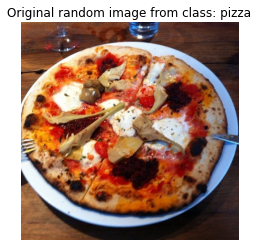

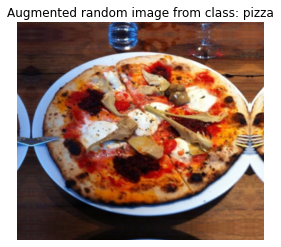

In [41]:
# Visualize data augmentation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = 'data/10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# data augmentation model requires shape (None, height, width, 3): Original - (height, width, 3)
# set training=True (to be explicit) since augmentation occurs only during model training
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


### model_0

In [35]:
IMG_SIZE + (3,)

(224, 224, 3)

In [53]:
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,), name='input_layer')

# Add augmentation layer
x = data_augmentation(inputs)

# Pass augmented inputs to model
# Pass training=false to run in inference mode
# So that patternes learned by BatchNormalization layers (on imagenet) dont get updated
x = base_model(x, training=False)

# Condense to feature vector & create outputs
x = layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
outputs = layers.Dense(10, activation='linear', name='output_layer')(x)

model_1 = keras.Model(inputs, outputs)
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history_1_percent = model_1.fit(
    train_data_1_percent,
    epochs=EPOCHS,
    steps_per_epoch=len(train_data_1_percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[create_tensorboard_callback(
        'tensorboard_logs/tensorboard_logs_fine_tuning',
        experiment_name='efficientnetB0_1_percent')
    ]
)

Saving TensorBoard log files to: tensorboard_logs/tensorboard_logs_fine_tuning/efficientnetB0_1_percent/20220924-081259


Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.3286 - accuracy: 0.1000WARNING:tensorflow:Model was constructed with shape (None, 512, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 512, 3), dtype=tf.uint8, name='random_flip_1_input'), name='random_flip_1_input', description="created by layer 'random_flip_1_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).


3/3 [==============================] - 58s 21s/step - loss: 2.3286 - accuracy: 0.1000 - val_loss: 2.1816 - val_accuracy: 0.1776
Epoch 2/5
3/3 [==============================] - 33s 16s/step - loss: 2.0956 - accuracy: 0.2143 - val_loss: 2.0490 - val_accuracy: 0.2780
Epoch 3/5
3/3 [==============================] - 38s 18s/step - loss: 1.8698 - accuracy: 0.4000 - val_loss: 1.9291 - val_accuracy: 0.3832
Epoch 4/5
3/3 [==============================] - 37s 17s/step - loss: 1.7211 - accuracy: 0.5143 - val_loss: 1.8466 - val_accuracy: 0.4359
Epoch 5/5
3/3 [==============================] - 38s 18s/step - loss: 1.5238 - accuracy: 0.5857 - val_loss: 1.7504 - val_accuracy: 0.5132


In [43]:
model_1.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

The data augmentation is built right into the model. This means the data augmentation layer will come with the model once we save and load it.

The important thing to remember is data augmentation only runs during training. So if we were to evaluate or use the model for predicting the data augmentation layers will be automatically turned off.

In [44]:
model_1.evaluate(test_data)

79/79 [==============================] - 128s 2s/step - loss: 1.7906 - accuracy: 0.4852


[1.7905982732772827, 0.4851999878883362]

Metric will be less than one obtained during training since it was checked against only 1/4th

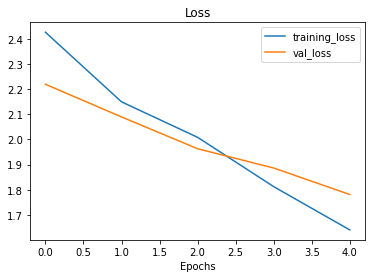

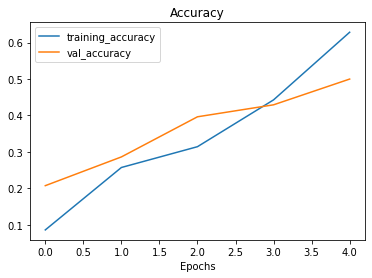

In [45]:
plot_loss_curves(history_1_percent)

### model_2

In [48]:
train_dir_10_percent = 'data/10_food_classes_10_percent/train/'
test_dir = 'data/10_food_classes_10_percent/test/'

In [52]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode=LABEL_MODE,
    image_size=IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode=LABEL_MODE,
    image_size=IMG_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [54]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    # layers.Rescaling(1/255.), # Not required for efficientnet
], name='data_augmentation')

base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
outputs = layers.Dense(10, activation='linear', name='output_layer')(x)
model_2 = keras.Model(inputs, outputs)

model_2.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [55]:
model_2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Create model checkpoint callback

Is typically a checkpoint for models during training. Helpful if the model will be training for a long time/can be trained for longer in future.

In [56]:
checkpoint_path = 'checkpoints/transfer learning/fine_tuning_model1'
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    # Don't save full model
    save_weights_only=True,
    # Save model every epoch, regardless of poorer performance
    save_best_only=False,
    save_freq='epoch',
    verbose=1
)

The `SavedModel` format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload exactly how it is elsewhere. However, if this is not necessary, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

In [58]:
history_10_percent = model_2.fit(
    train_data_10_percent,
    steps_per_epoch=len(train_data_10_percent),
    epochs=EPOCHS,
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[
        create_tensorboard_callback(
            'tensorboard_logs/tensorboard_logs_fine_tuning',
            experiment_name='efficientnetB0_10_percent'
        ),
        checkpoint_callback
    ]
)

Saving TensorBoard log files to: tensorboard_logs/tensorboard_logs_fine_tuning/efficientnetB0_10_percent/20220924-091756


Epoch 1/5


24/24 [==============================] - ETA: 0s - loss: 2.0832 - accuracy: 0.2973
Epoch 1: saving model to checkpoints/transfer learning\fine_tuning_model1
24/24 [==============================] - 115s 4s/step - loss: 2.0832 - accuracy: 0.2973 - val_loss: 1.5071 - val_accuracy: 0.6431
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3873 - accuracy: 0.6587
Epoch 2: saving model to checkpoints/transfer learning\fine_tuning_model1
24/24 [==============================] - 87s 4s/step - loss: 1.3873 - accuracy: 0.6587 - val_loss: 1.0504 - val_accuracy: 0.7780
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0717 - accuracy: 0.7507
Epoch 3: saving model to checkpoints/transfer learning\fine_tuning_model1
24/24 [==============================] - 79s 3s/step - loss: 1.0717 - accuracy: 0.7507 - val_loss: 0.8261 - val_accuracy: 0.8191
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8935 - accuracy: 0.7813
Epoch 4: saving model to che

In [59]:
model_2_results = model_2.evaluate(test_data)
model_2_results

79/79 [==============================] - 133s 2s/step - loss: 0.6405 - accuracy: 0.8412


[0.6405485272407532, 0.8411999940872192]

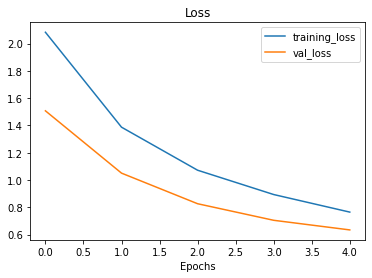

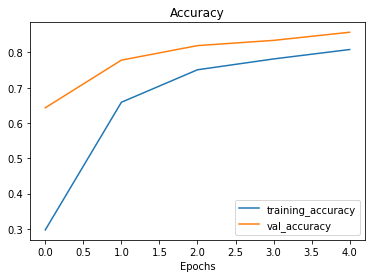

In [60]:
plot_loss_curves(history_10_percent)

### Load checkpoint weights

In [63]:
model_2.load_weights(checkpoint_path)

In [65]:
model_2_loaded_results = model_2.evaluate(test_data)
model_2_loaded_results

79/79 [==============================] - 143s 2s/step - loss: 0.6405 - accuracy: 0.8412


[0.6405484676361084, 0.8411999940872192]

In [66]:
model_2_results, model_2_loaded_results

([0.6405485272407532, 0.8411999940872192],
 [0.6405484676361084, 0.8411999940872192])

Results are pretty much the same (Slightly different just because of the computer precision)

### model_3

<img src='https://camo.githubusercontent.com/ee5c623437797bdc2e7c38e4c34be611180530adf18ebf93828f8f5d299aa096/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30352d66696e652d74756e696e672d616e2d656666696369656e746e65742d6d6f64656c2e706e67' />

Fine-tuned transfer learning is essentially unfreezing some of the layers (ones closest to the top) and running the model for a few more epochs.

**Side-note** Only the top layers are unfrozen because more bottom layers learn more general shapes

The idea with fine-tuning is to start customizing the pre-trained model more to the problems data

**Note**: Fine-tuning usually works best after training a feature extraction model for a few epochs and with large amounts of data

```javascript
build a feature extraction model -> train weights of output layer -> unfreeze some of the top layers
```

In [68]:
model_2.layers

In [69]:
# base model is untrainable
for layer in model_2.layers:
    print(layer.trainable)

True
True
False
True
True


In [70]:
model_2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [71]:
# How many variables are trainable in the base model
print(len(model_2.layers[2].trainable_variables))

0


The `learning_rate` dictates how much the model must update its internal patterns/weights from epoch to epoch, based on the optimizer & loss function

For fine-tuning, a rule-of-thumb is to lower the learning rate by 10x than normal.

LR is set very low to avoid model weights learning & updating existing weights too fast, since they're already learned weights

In [80]:
# Freeze layers except top 10
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False
    
# Must recompile model whenever the structure is changed
model_2.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=.0001),
    metrics=['accuracy']
)

In [76]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_9 False
1 rescaling_16 False
2 normalization_8 False
3 rescaling_17 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fa

In [77]:
print(len(model_2.layers[2].trainable_variables))

10


In [81]:
# Finetune model for another 5 epochs
fine_tune_epoch = EPOCHS + 5

history_10_percent_fine = model_2.fit(
    train_data_10_percent,
    epochs=fine_tune_epoch,
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    # Start training from previous models history last epoch
    initial_epoch=history_10_percent.epoch[-1],
    callbacks=[
        create_tensorboard_callback(
            'tensorboard_logs/tensorboard_logs_fine_tuning',
            experiment_name='efficientnetB0_10_percent_fine_tuned'
        ),
        checkpoint_callback
    ]
)

Saving TensorBoard log files to: tensorboard_logs/tensorboard_logs_fine_tuning/efficientnetB0_10_percent_fine_tuned/20220924-125150


Epoch 5/10


24/24 [==============================] - ETA: 0s - loss: 0.8245 - accuracy: 0.7867
Epoch 5: saving model to checkpoints/transfer learning\fine_tuning_model1
24/24 [==============================] - 156s 5s/step - loss: 0.8245 - accuracy: 0.7867 - val_loss: 0.5368 - val_accuracy: 0.8536
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.8360
Epoch 6: saving model to checkpoints/transfer learning\fine_tuning_model1
24/24 [==============================] - 98s 4s/step - loss: 0.6904 - accuracy: 0.8360 - val_loss: 0.4892 - val_accuracy: 0.8536
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.6218 - accuracy: 0.8507
Epoch 7: saving model to checkpoints/transfer learning\fine_tuning_model1
24/24 [==============================] - 92s 4s/step - loss: 0.6218 - accuracy: 0.8507 - val_loss: 0.4571 - val_accuracy: 0.8618
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.5568 - accuracy: 0.8680
Epoch 8: saving model to 

In [82]:
model_2_fine_tune_results = model_2.evaluate(test_data)

79/79 [==============================] - 165s 2s/step - loss: 0.4364 - accuracy: 0.8608


In [ ]:
plot_loss_curves(history_10_percent_fine)

In [98]:
# Create a function to compare histories
def compare_histories(original_history, new_history, initial_epochs=5):
    # original measurements
    orig_acc = original_history.history['accuracy']
    orig_loss = original_history.history['loss']
    orig_val_acc = original_history.history['val_accuracy']
    orig_val_loss = original_history.history['val_loss'] 

    # combine both
    total_acc = orig_acc + new_history.history['accuracy']
    total_loss = orig_loss + new_history.history['loss']
    total_val_acc = orig_val_acc + new_history.history['val_accuracy']
    total_val_loss = orig_val_loss + new_history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    # Plot vertical line to show start of fine-tuning
    plt.plot([EPOCHS - 1, EPOCHS - 1], plt.ylim(), label='Start finetuning')
    plt.legend(loc='lower right')
    plt.title('Training | Validation loss')
    
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([EPOCHS - 1, EPOCHS - 1], plt.ylim(), label='Start finetuning')
    plt.legend(loc='upper right')
    plt.title('Training | Validation Loss')
    

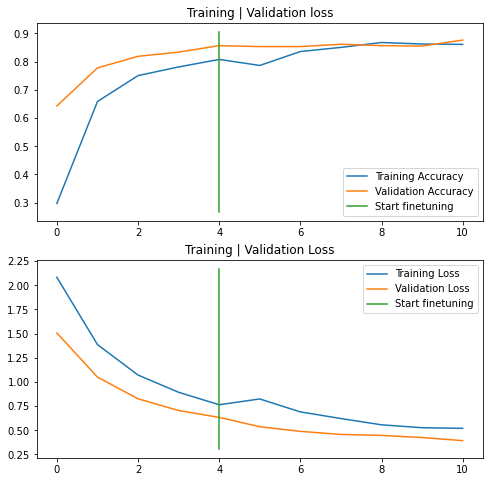

In [99]:
compare_histories(history_10_percent, history_10_percent_fine)